<table style="border: none" align="center">
   <tr style="border: none" align="left">
      <td style="border: none" align="left"><font face="verdana" size="4" color="black"><b>Building an object detection deep learning model and deploying it as a REST service</b></font></td>      
   </tr> 
   <tr style="border: none">
       <td style="border: none"><img src="https://images.indianexpress.com/2018/07/neelakurinji-kerala-tourism-org-balan-madhavan-759.jpg" width="600" alt="Icon"></td>
   </tr>
</table>

This notebook contains steps and code to train a deep learning model to identify objects using transfer learning technique. The model training will be done using Watson Machine Learning service. The trained model is then deployed as a ReST service that can be used for making real-time predictions. 
In this notebook, we will use Watson Machine Learning Python Client to interact with the Watson Machine Learning service.

Some familiarity with Python is helpful. This notebook uses Python 3.


## Learning goals

The learning goals of this notebook are:

-  Building a network to detect objects of interest in an image
-  Working with Watson Machine Learning experiments to train Deep Learning models (Keras).
-  Saving trained models in Watson Machine Learning repository.
-  Online deployment and scoring of trained model.


## Contents

This notebook contains the following parts:

1.	[Setup](#setup)
2.	[Training definition](#definition)
3.	[Experiment definition](#experiment)
4.	[Experiment Run](#run)
5.	[Deploy and Score](#scoring)
6.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Setup

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a [Watson Machine Learning Service](https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/) instance (a lite plan is offered). 
-  Create [Cloud Object Storage (COS)](https://console.bluemix.net/catalog/infrastructure/cloud-object-storage) instance (a lite plan is offered).
    - After you create COS instance, go to your COS dashboard.
    - In "Service credentials" tab, click on "New Credential",
    - Add inline configuration parameter: {"HMAC":true}, click "Add".

    This configuration parameter will add section below to instance credentials which will be used later on,
    ```
      "cos_hmac_keys": {
            "access_key_id": "722432c254bc4eaa96e05897bf2779e2",
            "secret_access_key": "286965ac10ecd4de8b44306288c7f5a3e3cf81976a03075c"
       }
    ```

### 1.1 Install required Python libraries

#### Install `watson-machine-learning-client` from pypi

In [ ]:
!pip install --upgrade watson-machine-learning-client

#### Install packages for visualizations

In [ ]:
!pip install cufflinks

#### Install wget package

In [ ]:
!pip install wget

### 1.2 Working with Cloud Object Storage

Boto library allows Python developers to manage Cloud Object Storage.

**Tip:** If ibm_boto3 is not preinstalled in you environment please install it by running the following command: `!pip install ibm-cos-sdk`

In [1]:
import ibm_boto3
from ibm_botocore.client import Config
import os
import json
import warnings
import time

We define the endpoint we will use. You can find this information in "Endpoint" section of your Cloud Object Storage intance's dashbord.

In [38]:

cos_credentials = {
  "apikey": "*****",
  "cos_hmac_keys": {
    "access_key_id": "****",
    "secret_access_key": "****"
  },
  "endpoints": "https://cos-service.bluemix.net/endpoints",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:cloud-object-storage:global:a/aab26fab86721e6737a39e414912e683:366a0811-19f8-49e6-862e-88812b3ed98f::",
  "iam_apikey_name": "auto-generated-apikey-17846d2e-0fb6-4f85-bfc4-2a9811b96a76",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/aab26fab86721e6737a39e414912e683::serviceid:ServiceId-fce2e66a-7fd1-436f-961e-2d1143e26784",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/aab26fab86721e6737a39e414912e683:366a0811-19f8-49e6-862e-88812b3ed98f::"
}

api_key = cos_credentials['apikey']
service_instance_id = cos_credentials['resource_instance_id']
auth_endpoint = 'https://iam.bluemix.net/oidc/token'
service_endpoint = 'https://s3.us-south.objectstorage.softlayer.net'

We create Boto resource by providing type, endpoint_url and credentials.

In [39]:
cos = ibm_boto3.resource('s3',
                         ibm_api_key_id=api_key,
                         ibm_service_instance_id=service_instance_id,
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=service_endpoint)

Let's create the buckets we will use to store training data and training results.

**Note:**: Bucket name has to be unique - please update below ones to any unique name.

In [40]:
buckets = ['transfer-learning-flower-data', 'transfer-learning-flower-results']

In [ ]:
for bucket in buckets:
    if not cos.Bucket(bucket) in cos.buckets.all():
        print('Creating bucket "{}"...'.format(bucket))
        try:
            cos.create_bucket(Bucket=bucket)
        except ibm_boto3.exceptions.ibm_botocore.client.ClientError as e:
            print('Error: {}.'.format(e.response['Error']['Message']))

Now we should have our buckets created.

In [ ]:
print(list(cos.buckets.all()))

### 1.2 Downloading flower data and upload it to COS buckets

We will work with **Flowers dataset** from University of Oxford to train the model. Let's download our training data and upload them to 'transfer-learning-flower-data' bucket. 

A subset of the **Flowers dataset** from University of Oxford is available in [here](https://github.com/krishnamurthy-a/Deep-Learning/raw/master/object-detection/data/flowers_data.zip). 

**Actions:**
- Download the dataset and extract it in your local system.
- Upload the extracted contents i.e the directory `flw_test` must be uploaded to 'transfer-learning-flower-data' bucket using IBM Cloud console. ([Ref.](https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml_dlaas_object_store.html?audience=wdp&context=wdp#createbucket))


Let's see the contents of the training data's bucket.

In [43]:
for obj in cos.Bucket(buckets[0]).objects.all():
    print('Object key: {}'.format(obj.key))
    print('Object size (kb): {}'.format(obj.size/1024))

Object key: flw_test/
Object size (kb): 0.0
Object key: flw_test/test/
Object size (kb): 0.0
Object key: flw_test/test/daffodil/
Object size (kb): 0.0
Object key: flw_test/test/daffodil/image_0071.jpg
Object size (kb): 32.6630859375
Object key: flw_test/test/daffodil/image_0072.jpg
Object size (kb): 26.8330078125
Object key: flw_test/test/daffodil/image_0073.jpg
Object size (kb): 48.6220703125
Object key: flw_test/test/daffodil/image_0074.jpg
Object size (kb): 29.4111328125
Object key: flw_test/test/daffodil/image_0075.jpg
Object size (kb): 56.4638671875
Object key: flw_test/test/daffodil/image_0076.jpg
Object size (kb): 41.1376953125
Object key: flw_test/test/daffodil/image_0077.jpg
Object size (kb): 40.275390625
Object key: flw_test/test/daffodil/image_0078.jpg
Object size (kb): 34.3984375
Object key: flw_test/test/daffodil/image_0079.jpg
Object size (kb): 38.09765625
Object key: flw_test/test/daffodil/image_0080.jpg
Object size (kb): 54.408203125
Object key: flw_test/test/sunflower/

We are done with Cloud Object Storage, we are ready to train our model!

### 1.3 Work with the Watson Machine Learning instance

Authenticate to Watson Machine Learning service on Bluemix.

In [13]:
import urllib3, requests, json, base64, time, os
warnings.filterwarnings('ignore')

**Action**: Put authentication information from your instance of Watson Machine Learning service here.

In [12]:
wml_credentials = {
  "url": "https://ibm-watson-ml.mybluemix.net",
  "access_key": "***",
  "username": "***",
  "password": "***",
  "instance_id": "***"
}


#### Import `watson-machine-learning-client` and authenticate to service instance

In [14]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

In [15]:
client = WatsonMachineLearningAPIClient(wml_credentials)

In [16]:
print(client.version)

1.0.313


<a id="definition"></a>
## 2. Training definitions

### 2.2 Save training definition 

#### Get model definition content files from git (python scripts with to train the model)

In [14]:
training_filename = 'wml_flowers_train.zip'

if os.path.isfile(training_filename):
    !ls 'wml_flowers_train.zip'
else:
    !wget https://github.com/krishnamurthy-a/Deep-Learning/raw/master/object-detection/wml/wml_flowers_train.zip
    !ls 'wml_flowers_train.zip'

wml_flowers_train.zip


#### Prepare training definition metadata

In [12]:
model_definition_1_metadata = {
            client.repository.DefinitionMetaNames.NAME: "t2-flowers-test2",
            client.repository.DefinitionMetaNames.FRAMEWORK_NAME: "tensorflow",
            client.repository.DefinitionMetaNames.FRAMEWORK_VERSION: "1.5",
            client.repository.DefinitionMetaNames.RUNTIME_NAME: "python",
            client.repository.DefinitionMetaNames.RUNTIME_VERSION: "3.5",
            client.repository.DefinitionMetaNames.EXECUTION_COMMAND: "python3 wml_train.py"
            }

#### Publish training definitions in Watson Machine Learning repository

##### Store definition 1

In [15]:
definition_1_details = client.repository.store_definition(training_filename, model_definition_1_metadata)

definition_1_url = client.repository.get_definition_url(definition_1_details)
definition_1_uid = client.repository.get_definition_uid(definition_1_details)
print(definition_1_url)

2018-08-25 04:48:25,876 - watson_machine_learning_client.metanames - WARNING - 'AUTHOR_EMAIL' meta prop is deprecated. It will be ignored.


https://us-south.ml.cloud.ibm.com/v3/ml_assets/training_definitions/13cf79cb-57b5-47e9-93fe-9c8d80624508


#### LIST stored definitions

In [16]:
client.repository.list_definitions()

------------------------------------  ---------------------  ------------------------  ----------
GUID                                  NAME                   CREATED                   FRAMEWORK
13cf79cb-57b5-47e9-93fe-9c8d80624508  t2-flowers-test2       2018-08-24T23:18:27.784Z  tensorflow
0841ab83-7446-4236-8126-440949fc62f6  tl-flowers-test1       2018-08-24T14:15:10.985Z  tensorflow
99cfd064-2dcd-4bdd-81bc-3c3a62891e2b  keras_mnist_train_def  2018-03-14T15:18:33.901Z  tensorflow
f89e8ec5-316b-401c-ba32-8677615ea533  experiment1            2017-12-11T07:16:56.772Z  tensorflow
------------------------------------  ---------------------  ------------------------  ----------


<a id="experiment"></a>
## 3. Experiment definition

### 3.1 Save experiment

#### Get the list of supported configuration params

In [17]:
client.repository.ExperimentMetaNames.show()

--------------------------  ----  --------
META_PROP NAME              TYPE  REQUIRED
NAME                        str   Y
DESCRIPTION                 str   N
TAGS                        list  N
AUTHOR_NAME                 str   N
EVALUATION_METHOD           str   N
EVALUATION_METRICS          list  N
TRAINING_REFERENCES         list  Y
TRAINING_DATA_REFERENCE     dict  Y
TRAINING_RESULTS_REFERENCE  dict  Y
--------------------------  ----  --------


#### Experiment configuration dictionary
Create experiment that will train models based on previously stored definitions.

`TRAINING_DATA_REFERENCE` - location of traininng data

In [18]:
TRAINING_DATA_REFERENCE = {
                            "connection": {
                                "endpoint_url": service_endpoint,
                                "access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                                "secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                            },
                            "source": {
                                "bucket": buckets[0],
                            },
                            "type": "s3"
}

`TRAINING_RESULTS_REFERENCE` - location of training results

In [19]:
TRAINING_RESULTS_REFERENCE = {
                                "connection": {
                                    "endpoint_url": service_endpoint,
                                    "access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                                    "secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                                },
                                "target": {
                                    "bucket": buckets[1],
                                },
                                "type": "s3"
}

Configure your experiment. `TRAINING_REFERENCES` links previously stored training definitions and provides information about `compute_configuration` that will be used to run the training.

In [60]:
experiment_metadata = {
            client.repository.ExperimentMetaNames.NAME: "Flw-trn1",
            client.repository.ExperimentMetaNames.DESCRIPTION: "Flw-trn1",
            client.repository.ExperimentMetaNames.AUTHOR_EMAIL: "k@ibm.com",
            client.repository.ExperimentMetaNames.EVALUATION_METHOD: "multiclass",
            client.repository.ExperimentMetaNames.EVALUATION_METRICS: ["val_acc"],            
            client.repository.ExperimentMetaNames.TRAINING_DATA_REFERENCE: TRAINING_DATA_REFERENCE,
            client.repository.ExperimentMetaNames.TRAINING_RESULTS_REFERENCE: TRAINING_RESULTS_REFERENCE,
            client.repository.ExperimentMetaNames.TRAINING_REFERENCES: [
                        {
                            "name": "flower-train-test",
                            "training_definition_url": definition_1_url,
                            "compute_configuration": {"name": "k80x2"}
                            
                        }
                      ]
            }

#### Store experiment in Watson Machine Learning repository

In [61]:
experiment_details = client.repository.store_experiment(meta_props=experiment_metadata)

experiment_uid = client.repository.get_experiment_uid(experiment_details)
print("Experiment UID: "+ experiment_uid)

2018-08-25 05:27:15,874 - watson_machine_learning_client.metanames - WARNING - 'AUTHOR_EMAIL' meta prop is deprecated. It will be ignored.


Experiment UID: ee9ad853-a52d-4ee7-8508-4600493a3906


#### LIST stored experiments

In [62]:
client.repository.list_experiments()

------------------------------------  -----------  ------------------------
GUID                                  NAME         CREATED
ee9ad853-a52d-4ee7-8508-4600493a3906  Flw-trn1     2018-08-24T23:57:18.415Z
50017ab0-237c-451b-befe-ef435c1b5d86  Flw-trn1     2018-08-24T23:46:22.501Z
b69dae4f-4cb6-4526-b6ea-aecdaefca3bb  Flw-trn1     2018-08-24T15:37:57.114Z
1864497e-cf89-4922-86b7-37c5517a1d18  Keras_mnist  2018-03-14T15:19:16.152Z
------------------------------------  -----------  ------------------------


**Hint:** You can update experiment definition by calling below method.

#### GET experiment definition details

In [48]:
details = client.repository.get_experiment_details(experiment_uid)

#### Delete experiment definition from repository

<a id="run"></a>
## 4. Run experiment

### 4.1 Running experiments

In [64]:
experiment_run_details = client.experiments.run(experiment_uid, asynchronous=True)

As we can see experiment run has been triggered.

#### LIST experiment runs
You can list experiment run using `client.experiments.list_runs()` method.

In [65]:
client.experiments.list_runs()

------------------------------------  ------------------------------------  -----------------  ---------  --------------------
GUID (experiment)                     GUID (run)                            NAME (experiment)  STATE      CREATED
ee9ad853-a52d-4ee7-8508-4600493a3906  bab33340-1042-4bcd-a5d6-659a527f6368  Flw-trn1           pending    2018-08-24T23:59:03Z
b69dae4f-4cb6-4526-b6ea-aecdaefca3bb  79f539a5-0c03-41d6-b8f0-e8e254e7c87f  Flw-trn1           completed  2018-08-24T15:39:53Z
------------------------------------  ------------------------------------  -----------------  ---------  --------------------


#### GET experiment run UID

In [66]:
experiment_run_uid = client.experiments.get_run_uid(experiment_run_details)
print(experiment_run_uid)

bab33340-1042-4bcd-a5d6-659a527f6368


#### LIST training runs triggered by experiment run

**Hint:** Please run the cell below several times durign the run to see updates.

In [70]:
client.experiments.list_training_runs(experiment_run_uid)

------------------  -----------------  ---------  --------------------  --------------------  --------------------
GUID (training)     NAME               STATE      SUBMITTED             FINISHED              PERFORMANCE
training-Hldv3wtig  flower-train-test  completed  2018-08-24T23:59:05Z  2018-08-25T00:02:03Z  test:acc=0.5437
                                                                                              test:loss=0.7343
                                                                                              test:val_acc=0.7500
                                                                                              test:val_loss=0.5210
------------------  -----------------  ---------  --------------------  --------------------  --------------------


#### GET run details
Use below method to get particular experiment run details.

In [71]:
experiment_run_details = client.experiments.get_run_details(experiment_run_uid)

In [72]:
experiment_run_details

{'metadata': {'guid': 'bab33340-1042-4bcd-a5d6-659a527f6368',
  'url': '/v3/experiments/ee9ad853-a52d-4ee7-8508-4600493a3906/runs/bab33340-1042-4bcd-a5d6-659a527f6368',
  'created_at': '2018-08-24T23:59:03Z',
  'modified_at': '2018-08-24T23:59:03Z'},
 'entity': {'experiment_run_status': {'best_results': {'experiment_best_model': {'training_guid': 'training-Hldv3wtig',
     'training_url': 'https://us-south.ml.cloud.ibm.com/v3/ml_assets/training_definitions/13cf79cb-57b5-47e9-93fe-9c8d80624508',
     'training_reference_name': 'flower-train-test'},
    'training_reference_best_model': [{'training_guid': 'training-Hldv3wtig',
      'training_url': 'https://us-south.ml.cloud.ibm.com/v3/ml_assets/training_definitions/13cf79cb-57b5-47e9-93fe-9c8d80624508',
      'training_reference_name': 'flower-train-test'}]},
   'state': 'completed',
   'submitted_at': '2018-08-24T23:59:04Z',
   'current_iteration': 1,
   'current_at': '2018-08-24T23:59:04Z'},
  'training_statuses': [{'training_guid': 't

#### GET experiment run status
You can check experiment run status by calling `client.experiments.get_status(run_uid)` method. This is quite useful when running experiment in background.

In [73]:
client.experiments.get_status(experiment_run_uid)

{'best_results': {'experiment_best_model': {'training_guid': 'training-Hldv3wtig',
   'training_url': 'https://us-south.ml.cloud.ibm.com/v3/ml_assets/training_definitions/13cf79cb-57b5-47e9-93fe-9c8d80624508',
   'training_reference_name': 'flower-train-test'},
  'training_reference_best_model': [{'training_guid': 'training-Hldv3wtig',
    'training_url': 'https://us-south.ml.cloud.ibm.com/v3/ml_assets/training_definitions/13cf79cb-57b5-47e9-93fe-9c8d80624508',
    'training_reference_name': 'flower-train-test'}]},
 'state': 'completed',
 'submitted_at': '2018-08-24T23:59:04Z',
 'current_iteration': 1,
 'current_at': '2018-08-24T23:59:04Z'}

#### GET experiment details
Use below method to get all information about particular experiment.

In [33]:
experiment_details = client.experiments.get_details(experiment_uid)

You can use below print method to display experiment details (change cell type to code).

In [34]:
print(json.dumps(experiment_details, indent=2))

{
  "resources": [
    {
      "metadata": {
        "guid": "4c258054-9e11-446e-919a-a70ccc3b126c",
        "url": "/v3/experiments/fe96afca-f26c-4578-a747-c9d29090b835/runs/4c258054-9e11-446e-919a-a70ccc3b126c",
        "created_at": "2018-08-24T23:29:40Z",
        "modified_at": "2018-08-24T23:29:40Z"
      },
      "entity": {
        "experiment_run_status": {
          "submitted_at": "2018-08-24T23:29:41Z",
          "current_at": "2018-08-24T23:29:41Z",
          "current_iteration": 1,
          "state": "error"
        },
        "training_statuses": [
          {
            "training_guid": "training-HHJ-9QtiR",
            "training_definition_url": "https://us-south.ml.cloud.ibm.com/v3/ml_assets/training_definitions/13cf79cb-57b5-47e9-93fe-9c8d80624508",
            "training_url": "/v3/models/training-HHJ-9QtiR",
            "state": "error",
            "role": "hpo",
            "finished_at": "2018-08-24T23:33:00Z",
            "submitted_at": "2018-08-24T23:29:43Z",


#### GET training runs uids

In [74]:
experiment_run_details = client.experiments.get_run_details(experiment_run_uid)
training_run_uids = client.experiments.get_training_uids(experiment_run_details)

for i in training_run_uids:
    print(i)

training-Hldv3wtig


#### Delete experiment-run

You can delete experiment runs and results by running below method.

**Tip:** the `delete` method can be also used to terminate experiment run

### 4.2 Monitoring experiment

#### MONITOR experiment run
You can monitor experiment run by calling `client.experiments.monitor_logs(run_uid)`. This method will stream training logs content to console.

**Tip:** You can also monitor particular training run by calling `client.training.monitor_logs(training_run_uid)`.
To get training_run_uid you can call method `client.experiments.list_training_runs(experiment_run_uid)`

In [ ]:
client.experiments.monitor_logs(experiment_run_uid)

**Note:** Before going to next section make sure that your experiment run has completed.

In [75]:
client.experiments.get_status(experiment_run_uid)['state']

'completed'

### 4.3 Quality metrics

#### Accessing metrics data

You can get final evaluation metrics by running below cell.

In [76]:
metrics = client.experiments.get_latest_metrics(experiment_run_uid)

You can get all evaluation metrics by running below code.

In [77]:
all_metrics = client.experiments.get_metrics(experiment_run_uid)

#### Visualize training results using plotly.

In [79]:
import sys
import pandas
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import plotly.graph_objs as go

init_notebook_mode(connected=True)
sys.path.append("".join([os.environ["HOME"]])) 

/usr/local/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:558: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis


/usr/local/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:531: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis




Let's put our final metrics data into pandas dataframe.

In [80]:
import pandas as pd

metrics_df = pd.DataFrame(columns=['GUID', 'NAME', 'METRIC NAME', 'METRIC VALUE'])

for m in metrics:
    for v in m['metrics']['values']:
            metrics_df = metrics_df.append({'GUID': m['training_guid'], 'NAME': m['training_reference_name'], 'METRIC NAME': v['name'], 'METRIC VALUE': v['value']}, ignore_index=True)
    
metrics_df

,GUID,NAME,METRIC NAME,METRIC VALUE
0,training-Hldv3wtig,flower-train-test,acc,0.543750
1,training-Hldv3wtig,flower-train-test,loss,0.734274
2,training-Hldv3wtig,flower-train-test,val_acc,0.750000
3,training-Hldv3wtig,flower-train-test,val_loss,0.521031


Visualize metrics data using grouped bar chart.

In [81]:
data = []

for i in list(pd.unique(metrics_df['METRIC NAME'])):
    data.append(go.Bar(x=metrics_df[metrics_df['METRIC NAME'].isin([i])]['GUID'] + ' (' + metrics_df[metrics_df['METRIC NAME'].isin([i])]['NAME'] + ')', y=metrics_df[metrics_df['METRIC NAME'].isin([i])]['METRIC VALUE'], name=i))


layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

## 5. Create online deployment

You can deployed stored model as webservice (online) by running below method.

### 5.1 Store trained model

#### Call this method to save model in Watson Machine Learning repository

In [82]:
status = client.experiments.get_status(experiment_run_uid)
best_model_uid = status['best_results']['experiment_best_model']['training_guid']
best_model_name = status['best_results']['experiment_best_model']['training_reference_name']

print(best_model_uid + ' (' +  best_model_name  + ')')

training-Hldv3wtig (flower-train-test)


In [83]:
saved_model_details = client.repository.store_model(best_model_uid, {'name': 'k_flw-test2'})

2018-08-25 05:42:02,824 - watson_machine_learning_client.metanames - WARNING - 'AUTHOR_EMAIL' meta prop is deprecated. It will be ignored.


**Tip:** Run below code to extract stored model guid from dictionary.

In [84]:
model_guid = client.repository.get_model_uid(saved_model_details)
print("Saved model guid: " + model_guid)

Saved model guid: afb2639c-953f-4204-bced-79b91dcaa188


#### Call this method to list stored models

In [88]:
client.repository.list_models()

------------------------------------  ---------------------------------------  ------------------------  -----------------
GUID                                  NAME                                     CREATED                   FRAMEWORK
afb2639c-953f-4204-bced-79b91dcaa188  k_flw-test2                              2018-08-25T00:12:05.757Z  tensorflow-1.5
833c5785-d18d-4c03-b8ac-950b95d7708d  k_flw-test1                              2018-08-24T15:46:28.320Z  tensorflow-1.5
76e457f1-06a4-44bb-a052-e5022a77787c  k_tt_flower_vgg19_t1                     2018-08-23T16:01:34.662Z  tensorflow-1.5
c6f7e229-48f7-4c33-bb39-3abb2c2f5331  cust_pyfunc_mnist                        2018-08-02T13:29:50.438Z  tensorflow-1.5
f7b12b0c-f2d3-44eb-8fb3-e5b4f8f3bebc  cust norm linalg_norm gnfuv1             2018-08-02T13:10:33.606Z  scikit-learn-0.19
dd0f9263-e210-44ed-b75d-5606f0cdee5f  cust norm linalg_norm gnfuv1             2018-07-26T14:21:21.689Z  scikit-learn-0.19
0167affd-ee86-4ef5-9f0a-82f623f6910a

### 5.2 Create online deployment

In [89]:
deployment_details = client.deployments.create(name="k_flwr_test3", model_uid=model_guid)



#######################################################################################

Synchronous deployment creation for uid: 'afb2639c-953f-4204-bced-79b91dcaa188' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS.....
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='e7ac36b9-75eb-4ad2-b9be-9a0178c54042'
------------------------------------------------------------------------------------------------




Extract `scoring endpoint` from deployment details.

In [90]:
scoring_url = client.deployments.get_scoring_url(deployment_details)
print(scoring_url)

https://ibm-watson-ml.mybluemix.net/v3/wml_instances/a91c300c-460b-4ebb-903f-992be2898028/deployments/e7ac36b9-75eb-4ad2-b9be-9a0178c54042/online


## 6. Scoring

Prepare sample scoring data to score deployed model.

In [17]:
from PIL import Image as pil_image
import numpy as np

Download a sunflower and daffodils image to predict

In [18]:
!wget https://images.pexels.com/photos/635529/pexels-photo-635529.jpeg

--2018-08-25 16:56:47--  https://images.pexels.com/photos/635529/pexels-photo-635529.jpeg
Resolving images.pexels.com... 104.16.241.112, 104.16.239.112, 104.16.242.112, ...
Connecting to images.pexels.com|104.16.241.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2914520 (2.8M) [image/jpeg]
Saving to: ‘pexels-photo-635529.jpeg’

pexels-photo-635529 100%[===================>]   2.78M  3.69MB/s    in 0.8s    

2018-08-25 16:56:48 (3.69 MB/s) - ‘pexels-photo-635529.jpeg’ saved [2914520/2914520]



In [22]:
!wget https://cdn.pixabay.com/photo/2017/03/21/17/27/daffodils-2162825_1280.jpg

--2018-08-25 17:00:37--  https://cdn.pixabay.com/photo/2017/03/21/17/27/daffodils-2162825_1280.jpg
Resolving cdn.pixabay.com... 213.239.228.180, 213.239.228.134, 213.239.228.182
Connecting to cdn.pixabay.com|213.239.228.180|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156391 (153K) [image/jpeg]
Saving to: ‘daffodils-2162825_1280.jpg’

daffodils-2162825_1 100%[===================>] 152.73K   461KB/s    in 0.3s    

2018-08-25 17:00:38 (461 KB/s) - ‘daffodils-2162825_1280.jpg’ saved [156391/156391]



In [21]:
image_path1 = "pexels-photo-635529.jpeg"
img1 = pil_image.open(image_path1)
img1 = img1.convert('RGB')

In [23]:
image_path2 = "daffodils-2162825_1280.jpg"
img2 = pil_image.open(image_path2)
img2 = img2.convert('RGB')

Let's plot two images.

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

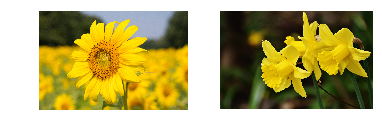

In [26]:
for i, image in enumerate([img1, img2]):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

Our input node expects to get data with shape (256, 256, 3) so we need to reshape our two images.

In [27]:
img1 = img1.resize((256, 256),pil_image.NEAREST)
x1 = np.asarray(img1, dtype='float32')

img2 = img2.resize((256, 256),pil_image.NEAREST)
x2 = np.asarray(img2, dtype='float32')

Prepare scoring payload and score.

In [28]:
scoring_data = {'values': [x1.tolist(), x2.tolist()]}

In [30]:
predictions = client.deployments.score(scoring_url, scoring_data)
print("Scoring result: " + str(predictions))

Scoring result: {'fields': ['prediction'], 'values': [[3.105196100250396e-09, 1.0], [0.9999973773956299, 2.600507514216588e-06]]}


##### Post process prediction result to show predicted flower names for the corresponding images. 
Notice the flower names on top of the images

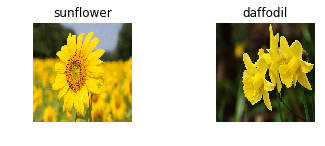

In [35]:
LABEL_MAPPING = {0: 'daffodil', 1: 'sunflower'}

consumable_prediction_result = []
for result in predictions['values']:
    consumable_prediction_result.append(LABEL_MAPPING[np.argmax(result)])

for i, image in enumerate([img1, img2]):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.title(consumable_prediction_result[i])
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

<a id="summary"></a>
## 7. Summary and next steps     

 You successfully completed this notebook! Check out our _[Online Documentation](https://console.ng.bluemix.net/docs/services/PredictiveModeling/index.html)_ for more samples, tutorials, documentation, how-tos, and blog posts. 

Copyright © 2018 IBM. This notebook and its source code are released under the terms of the MIT License.